In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

csv_train = pd.read_csv("../../data/train_data/Simon_train_3.csv")
df_train = pd.DataFrame(csv_train)

df_time_offset = df_train["Timestamp"][0]
df_train["Timestamp"] = df_train["Timestamp"] - df_time_offset
df_train

,Timestamp,a_x,a_y,a_z,g_x,g_y,g_z,w_x,w_y,w_z,r_x,r_y,r_z,q_w,q_x,q_y,q_z
0,0.000000,-0.004732,-0.690689,-0.726169,0.534539,0.058521,-0.165964,0.0,0.0,0.0,47.377846,-0.609170,-45.406113,0.845599,-0.368757,0.159554,0.351459
1,0.009995,-0.002709,-0.698488,-0.724475,0.409979,0.054647,0.095046,0.0,0.0,0.0,47.381931,-0.609500,-45.405064,0.845589,-0.368787,0.159566,0.351445
2,0.019997,-0.003355,-0.695562,-0.726584,0.197535,-0.101003,0.048017,0.0,0.0,0.0,47.383907,-0.610535,-45.405483,0.845583,-0.368798,0.159581,0.351442
3,0.029999,-0.002963,-0.695249,-0.725356,0.109812,-0.219404,-0.035955,0.0,0.0,0.0,47.385029,-0.611754,-45.407349,0.845575,-0.368800,0.159599,0.351450
4,0.039993,-0.002754,-0.695206,-0.724380,0.217217,-0.303979,-0.087488,0.0,0.0,0.0,47.127167,-0.566297,-45.254425,0.846813,-0.367248,0.157983,0.350826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,599.960007,-0.153711,-0.962468,-0.193948,-0.202359,1.699549,-0.681699,0.0,0.0,0.0,78.837799,-8.630409,-102.535255,0.519256,-0.350830,0.530303,0.571026
59997,599.969955,-0.149983,-0.962639,-0.190256,0.686184,2.019532,-0.731934,0.0,0.0,0.0,78.841873,-8.619314,-102.516655,0.519292,-0.350995,0.530223,0.570965
59998,599.979965,-0.143293,-0.970871,-0.190805,1.290162,1.770548,-0.626909,0.0,0.0,0.0,78.852333,-8.609745,-102.500313,0.519303,-0.351171,0.530188,0.570880
59999,599.989975,-0.138863,-0.984151,-0.188710,1.167098,0.943729,-0.554751,0.0,0.0,0.0,78.877586,-8.571616,-102.526077,0.518945,-0.351376,0.530245,0.571027


In [2]:
POSE_MAP= {
    "rett": 0,
    "framover": 1,
    "bakover": 2,
    "venstre": 3,
    "hoyre": 4
}

In [3]:
def get_timestamp_and_pose(filename):
    rows = []
    with open(filename, "r") as f:
        lines = f.readlines()
        offset = float(lines[1].strip().split(";")[1]) # This offset is the duration spent in the video before recording of data begun.
        for l in lines[1:]:
            sep_row = l.strip().split(";")
            finished_row = [round(float(x)-offset,2) for x in sep_row[1:3]]
            finished_row.append(POSE_MAP[sep_row[3].lower()])
            rows.append(finished_row)
    return rows

[[0.0, 122.4, 0], [123.6, 240.96, 1], [243.2, 360.52, 3], [362.68, 482.12, 4], [484.2, 602.92, 2]]
59233
59233


<AxesSubplot:xlabel='Timestamp', ylabel='Pose'>

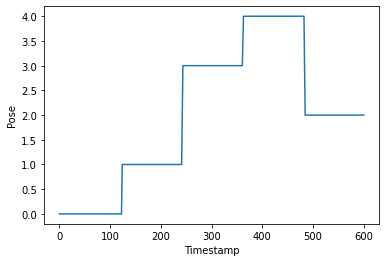

In [4]:
f_name = "../../data/train_data/simon_train_3.txt"
stamped_poses = get_timestamp_and_pose(f_name)
print(stamped_poses)

df_stamped_poses = []
pose_index = 0
row_index = 0
for stamp in df_train["Timestamp"]:  
    pose_id = -1
    if stamp <= stamped_poses[-1][1]: 
        if stamp > stamped_poses[pose_index][1]:
            pose_index += 1
        pose_id = stamped_poses[pose_index][2]
        # If timestamp is in new index, but haven't reached the starting time of this interval yet, set pose_id to default value 5.
        if stamp >= stamped_poses[pose_index][0]:
            df_stamped_poses.append(pose_id)
        else:
            df_train = df_train.drop(row_index)
    row_index += 1

    # If timestamp of the data point exceeds last timestamp recorded by the annotation, append default -1 value
    #df_stamped_poses.append(pose_id)

#print(df_stamped_poses)

df_train["Pose"] = df_stamped_poses
#print(df[2400:2500][:])
print(len(df_train.index))
print(len(df_stamped_poses))
y_train = df_train["Pose"]
#df['Pose'].hist(bins=4)
sns.lineplot(data=df_train, x="Timestamp", y='Pose')

In [5]:
x_train = df_train.drop(['Timestamp'],axis=1)
x_train = x_train.drop(['Pose'],axis=1)
x_train

,a_x,a_y,a_z,g_x,g_y,g_z,w_x,w_y,w_z,r_x,r_y,r_z,q_w,q_x,q_y,q_z
0,-0.004732,-0.690689,-0.726169,0.534539,0.058521,-0.165964,0.0,0.0,0.0,47.377846,-0.609170,-45.406113,0.845599,-0.368757,0.159554,0.351459
1,-0.002709,-0.698488,-0.724475,0.409979,0.054647,0.095046,0.0,0.0,0.0,47.381931,-0.609500,-45.405064,0.845589,-0.368787,0.159566,0.351445
2,-0.003355,-0.695562,-0.726584,0.197535,-0.101003,0.048017,0.0,0.0,0.0,47.383907,-0.610535,-45.405483,0.845583,-0.368798,0.159581,0.351442
3,-0.002963,-0.695249,-0.725356,0.109812,-0.219404,-0.035955,0.0,0.0,0.0,47.385029,-0.611754,-45.407349,0.845575,-0.368800,0.159599,0.351450
4,-0.002754,-0.695206,-0.724380,0.217217,-0.303979,-0.087488,0.0,0.0,0.0,47.127167,-0.566297,-45.254425,0.846813,-0.367248,0.157983,0.350826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59996,-0.153711,-0.962468,-0.193948,-0.202359,1.699549,-0.681699,0.0,0.0,0.0,78.837799,-8.630409,-102.535255,0.519256,-0.350830,0.530303,0.571026
59997,-0.149983,-0.962639,-0.190256,0.686184,2.019532,-0.731934,0.0,0.0,0.0,78.841873,-8.619314,-102.516655,0.519292,-0.350995,0.530223,0.570965
59998,-0.143293,-0.970871,-0.190805,1.290162,1.770548,-0.626909,0.0,0.0,0.0,78.852333,-8.609745,-102.500313,0.519303,-0.351171,0.530188,0.570880
59999,-0.138863,-0.984151,-0.188710,1.167098,0.943729,-0.554751,0.0,0.0,0.0,78.877586,-8.571616,-102.526077,0.518945,-0.351376,0.530245,0.571027


In [6]:

print(y_train)
print(len(y_train))

0        0
1        0
2        0
3        0
4        0
        ..
59996    2
59997    2
59998    2
59999    2
60000    2
Name: Pose, Length: 59233, dtype: int64
59233


In [7]:
csv_test = pd.read_csv("../../data/test_data/Simon_test_1.csv")
df_test = pd.DataFrame(csv_test)
df_time_offset = df_test["Timestamp"][0]
df_test["Timestamp"] = df_test["Timestamp"] - df_time_offset
df_test

,Timestamp,a_x,a_y,a_z,g_x,g_y,g_z,w_x,w_y,w_z,r_x,r_y,r_z,q_w,q_x,q_y,q_z
0,0.000000,0.062783,-0.664359,-0.745311,-1.486327,-0.954215,-1.100742,0.0,0.0,0.0,45.977032,2.722177,-50.473026,0.828528,-0.362494,0.146685,0.400777
1,0.010000,0.068403,-0.668227,-0.748759,0.846733,-0.104457,-2.227663,0.0,0.0,0.0,45.984718,2.737466,-50.489273,0.828422,-0.362581,0.146652,0.400930
2,0.020000,0.071032,-0.672759,-0.749368,0.630087,-0.068906,-1.911747,0.0,0.0,0.0,45.729458,2.834796,-50.418976,0.829316,-0.361150,0.144826,0.401037
3,0.030001,0.073829,-0.674456,-0.750533,0.789155,0.104108,-1.864622,0.0,0.0,0.0,45.736748,2.848875,-50.431267,0.829227,-0.361234,0.144787,0.401159
4,0.039999,0.074100,-0.673934,-0.749086,0.912611,-0.007038,-1.740844,0.0,0.0,0.0,45.745266,2.861296,-50.443478,0.829138,-0.361322,0.144765,0.401274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,59.959995,0.288413,-0.607716,-0.857441,16.279032,-0.668786,-7.142547,0.0,0.0,0.0,33.901562,12.762970,-46.368332,0.861102,-0.308202,0.016335,0.404039
5997,59.969997,0.267898,-0.616100,-0.847874,16.176073,-1.929723,-5.452105,0.0,0.0,0.0,34.064842,12.784996,-46.423275,0.860428,-0.309486,0.016889,0.404472
5998,59.980000,0.243766,-0.607581,-0.840962,16.973791,-2.367597,-3.386166,0.0,0.0,0.0,34.225212,12.784409,-46.465641,0.859845,-0.310682,0.017575,0.404764
5999,59.990002,0.226962,-0.590494,-0.836024,18.708357,-3.271112,-2.419889,0.0,0.0,0.0,34.403584,12.771029,-46.505039,0.859246,-0.311974,0.018415,0.405005


In [8]:
test_name = "../../data/annotation/Simon_test_1.txt"
stamped_poses = get_timestamp_and_pose(test_name)
print(stamped_poses)

df_stamped_poses = []
pose_index = 0
row_index = 0
drops = 0
for stamp in df_test["Timestamp"]:  
    pose_id = -1
    if stamp <= stamped_poses[-1][1] and stamp >= stamped_poses[0][0]:
        if stamp > stamped_poses[pose_index][1]:
            pose_index += 1
        pose_id = stamped_poses[pose_index][2]
        # If timestamp is in new index, but haven't reached the starting time of this interval yet, set pose_id to default value 5.
        if stamp >= stamped_poses[pose_index][0]:
            df_stamped_poses.append(pose_id)
        else:
            df_test = df_test.drop(row_index)
    else:
        df_test = df_test.drop(row_index)
    row_index += 1

    # If timestamp of the data point exceeds last timestamp recorded by the annotation, append default -1 value
    #df_stamped_poses.append(pose_id)

#print(df_stamped_poses)
print(len(df_test.index))
print("drops: {}".format(drops))
print(len(df_stamped_poses))
df_test["Pose"] = df_stamped_poses
y_test = df_stamped_poses
#print(df[2400:2500][:])

[[0.0, 12.28, 0], [12.6, 22.64, 1], [24.16, 31.64, 3], [32.76, 42.0, 4], [42.64, 58.64, 2]]
5505
drops: 0
5505


In [9]:
df_test

,Timestamp,a_x,a_y,a_z,g_x,g_y,g_z,w_x,w_y,w_z,r_x,r_y,r_z,q_w,q_x,q_y,q_z,Pose
0,0.000000,0.062783,-0.664359,-0.745311,-1.486327,-0.954215,-1.100742,0.0,0.0,0.0,45.977032,2.722177,-50.473026,0.828528,-0.362494,0.146685,0.400777,0
1,0.010000,0.068403,-0.668227,-0.748759,0.846733,-0.104457,-2.227663,0.0,0.0,0.0,45.984718,2.737466,-50.489273,0.828422,-0.362581,0.146652,0.400930,0
2,0.020000,0.071032,-0.672759,-0.749368,0.630087,-0.068906,-1.911747,0.0,0.0,0.0,45.729458,2.834796,-50.418976,0.829316,-0.361150,0.144826,0.401037,0
3,0.030001,0.073829,-0.674456,-0.750533,0.789155,0.104108,-1.864622,0.0,0.0,0.0,45.736748,2.848875,-50.431267,0.829227,-0.361234,0.144787,0.401159,0
4,0.039999,0.074100,-0.673934,-0.749086,0.912611,-0.007038,-1.740844,0.0,0.0,0.0,45.745266,2.861296,-50.443478,0.829138,-0.361322,0.144765,0.401274,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860,58.600002,0.099358,-0.909806,-0.466755,-32.147751,2.096320,-4.124378,0.0,0.0,0.0,59.219334,4.326933,-46.493744,0.790895,-0.466605,0.164718,0.360045,2
5861,58.609997,0.093769,-0.900051,-0.472275,-33.172920,-0.092982,-4.153292,0.0,0.0,0.0,58.885906,4.362067,-46.515957,0.792111,-0.464371,0.163513,0.360810,2
5862,58.619999,0.084923,-0.893159,-0.474635,-34.149380,-1.064418,-4.035158,0.0,0.0,0.0,58.555283,4.391699,-46.545895,0.793295,-0.462125,0.162383,0.361600,2
5863,58.630001,0.071399,-0.885253,-0.478109,-34.443287,-1.770149,-2.932498,0.0,0.0,0.0,58.208508,4.407387,-46.576435,0.794563,-0.459725,0.161299,0.362361,2


In [10]:
x_test = df_test.drop(['Timestamp'],axis=1)
x_test = x_test.drop(['Pose'],axis=1)
x_test

,a_x,a_y,a_z,g_x,g_y,g_z,w_x,w_y,w_z,r_x,r_y,r_z,q_w,q_x,q_y,q_z
0,0.062783,-0.664359,-0.745311,-1.486327,-0.954215,-1.100742,0.0,0.0,0.0,45.977032,2.722177,-50.473026,0.828528,-0.362494,0.146685,0.400777
1,0.068403,-0.668227,-0.748759,0.846733,-0.104457,-2.227663,0.0,0.0,0.0,45.984718,2.737466,-50.489273,0.828422,-0.362581,0.146652,0.400930
2,0.071032,-0.672759,-0.749368,0.630087,-0.068906,-1.911747,0.0,0.0,0.0,45.729458,2.834796,-50.418976,0.829316,-0.361150,0.144826,0.401037
3,0.073829,-0.674456,-0.750533,0.789155,0.104108,-1.864622,0.0,0.0,0.0,45.736748,2.848875,-50.431267,0.829227,-0.361234,0.144787,0.401159
4,0.074100,-0.673934,-0.749086,0.912611,-0.007038,-1.740844,0.0,0.0,0.0,45.745266,2.861296,-50.443478,0.829138,-0.361322,0.144765,0.401274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860,0.099358,-0.909806,-0.466755,-32.147751,2.096320,-4.124378,0.0,0.0,0.0,59.219334,4.326933,-46.493744,0.790895,-0.466605,0.164718,0.360045
5861,0.093769,-0.900051,-0.472275,-33.172920,-0.092982,-4.153292,0.0,0.0,0.0,58.885906,4.362067,-46.515957,0.792111,-0.464371,0.163513,0.360810
5862,0.084923,-0.893159,-0.474635,-34.149380,-1.064418,-4.035158,0.0,0.0,0.0,58.555283,4.391699,-46.545895,0.793295,-0.462125,0.162383,0.361600
5863,0.071399,-0.885253,-0.478109,-34.443287,-1.770149,-2.932498,0.0,0.0,0.0,58.208508,4.407387,-46.576435,0.794563,-0.459725,0.161299,0.362361


number of correct: 5192
number of guesses: 5505
% correct: 94.31425976385106
K: 1
[94.31425976385106]
[1]
number of correct: 5185
number of guesses: 5505
% correct: 94.18710263396912
K: 2
[94.31425976385106, 94.18710263396912]
[1, 2]
number of correct: 5191
number of guesses: 5505
% correct: 94.2960944595822
K: 3
[94.31425976385106, 94.18710263396912, 94.2960944595822]
[1, 2, 3]
number of correct: 5185
number of guesses: 5505
% correct: 94.18710263396912
K: 4
[94.31425976385106, 94.18710263396912, 94.2960944595822, 94.18710263396912]
[1, 2, 3, 4]
number of correct: 5189
number of guesses: 5505
% correct: 94.25976385104451
K: 5
[94.31425976385106, 94.18710263396912, 94.2960944595822, 94.18710263396912, 94.25976385104451]
[1, 2, 3, 4, 5]
number of correct: 5177
number of guesses: 5505
% correct: 94.04178019981835
K: 6
[94.31425976385106, 94.18710263396912, 94.2960944595822, 94.18710263396912, 94.25976385104451, 94.04178019981835]
[1, 2, 3, 4, 5, 6]
number of correct: 5181
number of guess

<AxesSubplot:xlabel='k', ylabel='%'>

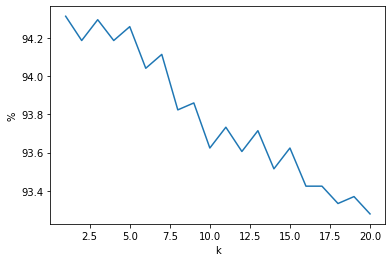

In [12]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import NeighborhoodComponentsAnalysis,KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

k = 1
accuracy_array = []
k_array = []
for num in range(20):
    
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train,y_train)
    predictions = neigh.predict(x_test)
    number_of_corrects = 0
   
    for num in range(len(predictions)):
        if(predictions[num] == y_test[num]):
            number_of_corrects += 1

    print("number of correct: {}".format(number_of_corrects))
    print("number of guesses: {}".format(len(predictions)))
    print("% correct: {}".format(number_of_corrects/len(predictions)*100))
    accuracy_array.append(number_of_corrects/len(predictions)*100)
    k_array.append(k)
    print("K: {}".format(k))
    k += 1
    print(accuracy_array)
    print(k_array)

resframe = pd.DataFrame({'k':k_array, '%':accuracy_array})
resframe
    

sns.lineplot(data=resframe,x="k",y="%")


In [13]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis,KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(x_train,y_train)
predictions = neigh.predict(x_test)


In [14]:
for num in range(len(predictions)):
    print(predictions[num])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


<AxesSubplot:xlabel='x', ylabel='y'>

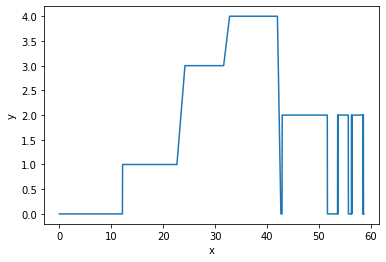

In [15]:
df_predict = pd.DataFrame({'x':df_test['Timestamp'],'y':predictions})
sns.lineplot(data=df_predict,x='x',y='y')

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions, zero_division=True))

[[1215   14    0    0    0]
 [   0 1004    0    0    0]
 [ 299    0 1301    0    0]
 [   0    0    0  748    0]
 [   0    0    0    0  924]]
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1229
           1       0.99      1.00      0.99      1004
           2       1.00      0.81      0.90      1600
           3       1.00      1.00      1.00       748
           4       1.00      1.00      1.00       924

    accuracy                           0.94      5505
   macro avg       0.96      0.96      0.96      5505
weighted avg       0.95      0.94      0.94      5505



<AxesSubplot:>

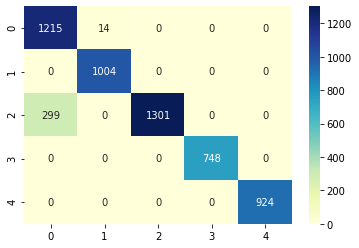

In [17]:
sns.heatmap(confusion_matrix(y_test, predictions), cmap="YlGnBu", annot=True, fmt="d")

In [18]:
number_of_corrects = 0
for num in range(len(predictions)):
    if(predictions[num] == y_test[num]):
        number_of_corrects += 1

print("number of correct: {}".format(number_of_corrects))
print("number of guesses: {}".format(len(predictions)))
print("% correct: {}".format(number_of_corrects/len(predictions)*100))

number of correct: 5192
number of guesses: 5505
% correct: 94.31425976385106
